In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update(plt.rcParamsDefault)
import os, sys
import scipy.stats as stats
from scipy.stats import norm, skewnorm
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, make_scorer, mean_squared_error

import xgboost as xgb
from xgboost_distribution import XGBDistribution
from xgboost_distribution.metrics import get_ll_score_func
from xgboost import plot_importance
import itertools

In [4]:
proj_dir = 'C:/Users/ady05/Desktop/NU/DANA/NVQI/prob_learning_new/'
workspace = proj_dir + 'XgbDist/xgb-nihss/'
util_dir = proj_dir + 'XgbDist/utils/'
data_dir = proj_dir + 'datasets/'
proc_dir = proj_dir + 'data processing/'

# Data Processing

In [7]:
df_data = pd.read_excel(proc_dir + 'dataDC.xlsx')
df_num = pd.read_excel(data_dir + 'numDC.xlsx')
df_cat = pd.read_excel(data_dir + 'catDC.xlsx')

groupname = 'group preop'

In [8]:
X_data, y_data, num_names, cat_names = data_proc_nihss2(df_data, df_num, df_cat, groupname)
(X_data.shape, y_data.shape)

((3163, 54), (3163,))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, train_size=0.8, random_state=1121218
)

(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((2530, 54), (2530,), (633, 54), (633,))

# XGBDistribution

In [15]:
distribution = "normal"
max_depth_val = [1, 2, 3, 4, 5]
n_estimators_val = [5, 10, 20, 100]
param_grid = {"n_estimators": n_estimators_val, "max_depth": max_depth_val}
xgb_cv = GridSearchCV(XGBDistribution(distribution=distribution),
                      param_grid,
                      cv=5,
                      scoring={f"{distribution}_ll": make_scorer(get_ll_score_func(distribution)),},
                      refit=False,)
xgb_cv.fit(X_train, y_train)

,estimator,"XGBDistributi...obs=None, ...)"
,param_grid,"{'max_depth': [1, 2, ...], 'n_estimators': [5, 10, ...]}"
,scoring,{'normal_ll': make_scorer(s...hod='predict')}
,n_jobs,None
,refit,False
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,distribution,'normal'


In [18]:
best_params = [{'max_depth': d, 'n_estimators': n} for d in max_depth_val for n in n_estimators_val]

# To select the best parameters based on best_index
best_index = np.argmax(xgb_cv.cv_results_['mean_test_normal_ll'])
selected_params = best_params[best_index]
print(selected_params)

{'max_depth': 5, 'n_estimators': 20}


In [10]:
model = XGBDistribution(
    distribution="normal",
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.01,
    reg_lambda=5,
    gamma=0.1,)

model.fit(X_train, y_train, verbose=False)
preds = model.predict(X_test)

# Measures

In [13]:
def root_mean_squared_error(y_pred, y_test):
    return np.sqrt(mean_squared_error(y_pred, y_test))
def normal_nll(loc, scale, y_test):
    return -norm.logpdf(y_test.flatten(), loc=loc, scale=scale).mean()
def tsn_nll(y_test, preds):
    U, L = 6.0, 0.0
    y = np.asarray(y_test, dtype=np.float64).ravel()
    mu = np.asarray(preds.loc, dtype=np.float64).ravel()
    sc = np.asarray(preds.scale, dtype=np.float64).ravel()   
    sk = np.asarray(getattr(preds, "skew", np.zeros_like(mu)), dtype=np.float64).ravel()
    base_pdf = np.clip(skewnorm.pdf(y, a=sk, loc=mu, scale=sc), 1e-12, None)
    Z = np.clip(skewnorm.cdf(U, a=sk, loc=mu, scale=sc) - 
                skewnorm.cdf(L, a=sk, loc=mu, scale=sc), 1e-12, None)
    return -np.log(base_pdf / Z).mean()
def normalized_rmse(y_pred, y_test):
    rmse = np.sqrt(mean_squared_error(y_pred, y_test))
    rng  = y_test.max() - y_test.min()
    return rmse / rng

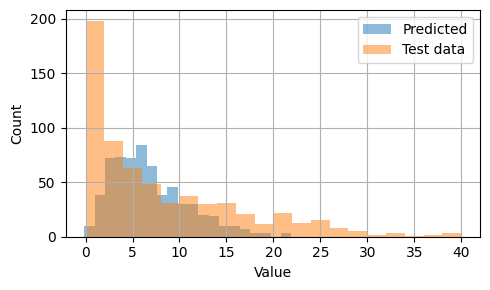

In [16]:
plt.figure(figsize=(5, 3))
plt.hist(preds.loc, bins=20, alpha=0.5, label='Predicted')
plt.hist(y_test,         bins=20, alpha=0.5, label='Test data')
plt.legend(loc='upper right')
plt.xlabel('Value')
plt.ylabel('Count')      # or 'Density' if density=True
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
def plot_residuals(y_true, y_pred, y_err):
    fig, ax = plt.subplots()
    ax.errorbar(
        y_true,
        y_true - y_pred,
        yerr=y_err,
        marker="o",
        linestyle="None",
        c="k",
        markersize=2.5,
        linewidth=0.5,
    )
    ax.axhline(0, c="k", linestyle="--")
    ax.set_xlabel("Actual data")
    ax.set_ylabel("Residuals: Actual - Predicted")
    plt.show()

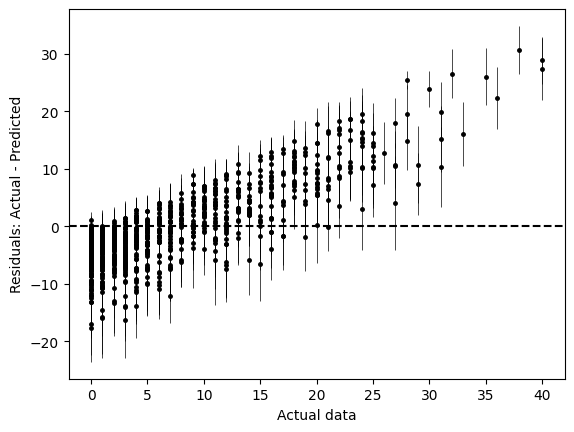

In [22]:
plot_residuals(y_test, preds.loc, preds.scale)

In [23]:
mean, std = preds.loc, preds.scale

In [24]:
y_mean = np.squeeze(np.mean(y_test))   

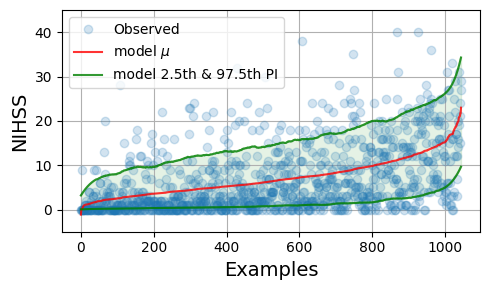

In [26]:
def tsn_cdf_scalar(t, loc, scale, skew, L=0.0, U=42.0, eps=1e-12):
    t = float(np.clip(t, L, U))
    FL = np.clip(skewnorm.cdf(L, a=skew, loc=loc, scale=scale), eps, 1.0 - eps)
    FU = np.clip(skewnorm.cdf(U, a=skew, loc=loc, scale=scale), eps, 1.0 - eps)
    Z  = np.clip(FU - FL, eps, None)
    Ft = np.clip(skewnorm.cdf(t, a=skew, loc=loc, scale=scale), eps, 1.0 - eps)
    return float(np.clip((Ft - FL) / Z, 0.0, 1.0))

def q_tsn(p, loc, scale, skew, L=0.0, U=42.0, iters=60):
    a, b = L, U
    for _ in range(iters):
        m = 0.5*(a+b)
        if tsn_cdf_scalar(m, loc, scale, skew, L, U) < p:
            a = m
        else:
            b = m
    return 0.5*(a+b)

y_true = np.squeeze(y_test)

loc  = np.asarray(preds.loc,   float).ravel()
scale= np.asarray(preds.scale, float).ravel()
skew = np.zeros(len(scale))
n = len(y_true)

q05 = np.array([q_tsn(0.025, loc[i], scale[i], skew[i]) for i in range(n)])
q95 = np.array([q_tsn(0.975, loc[i], scale[i], skew[i]) for i in range(n)])

order  = np.argsort(loc)
x      = np.arange(len(y_test))
q05_o  = q05[order]
q95_o  = q95[order]
y_true_o = y_true[order]
y_mean_o = loc[order]

def _moving_avg(arr, win):
    win = max(5, int(win));  win += (win % 2 == 0)  # odd
    k = np.ones(win) / win
    return np.convolve(arr, k, mode='same')

try:
    from scipy.signal import savgol_filter
    def smooth(arr, frac=0.08, poly=3):
        n = len(arr)
        win = int(max(11, frac * n))
        if win % 2 == 0: win += 1
        win = min(win - (win > n), n - (1 - n % 2))  
        win = max(win, poly + 2 + ((poly + 2) % 2 == 0))  
        return savgol_filter(arr, window_length=win, polyorder=poly, mode='interp')
except Exception:
    def smooth(arr, frac=0.08, poly=None):
        n = len(arr)
        win = int(max(11, frac * n))
        return _moving_avg(arr, win)

q05_s = smooth(q05_o, frac=0.08, poly=3)
q95_s = smooth(q95_o, frac=0.08, poly=3)

q05_s = np.clip(q05_s, 0.0, 42.0)
q95_s = np.clip(q95_s, 0.0, 42.0)
mid   = 0.5 * (q05_s + q95_s)
half  = 0.5 * np.maximum(q95_s - q05_s, 1e-6)
q05_s = mid - half
q95_s = mid + half

plt.figure(figsize=(5, 3))
plt.plot(y_true_o, 'o', alpha=0.2, label='Observed')
plt.plot(y_mean_o, color='red', alpha=0.8, label='model $\\mu$')
plt.plot(q05_s, color='green', alpha=0.15)
plt.plot(q95_s, color='green', alpha=0.15)
plt.plot(q05_s, color='green', alpha=0.8, label='model 2.5th & 97.5th PI')
plt.plot(q95_s, color='green', alpha=0.8)
plt.fill_between(x, q05_s, q95_s, alpha=0.10, color='green')
plt.xlabel('Examples', fontsize=14); plt.ylabel('NIHSS', fontsize=14)
plt.ylim(-5, 45); plt.legend(loc='upper left'); plt.grid(True); plt.tight_layout()
plt.show()

# Feature Importance

In [17]:
feature_names = num_names + cat_names
booster = model.get_booster()
booster.feature_names = feature_names

# Get feature importance
importance = booster.get_score(importance_type='gain')  
importance = {k: round(v, 2) for k, v in importance.items()}
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)  # Sort features by importance
features, scores = zip(*importance)  

total_score = sum(scores)
scores = [(score / total_score) * 100 for score in scores]

# top_n = 20
# features = features[:top_n]
# scores = scores[:top_n]

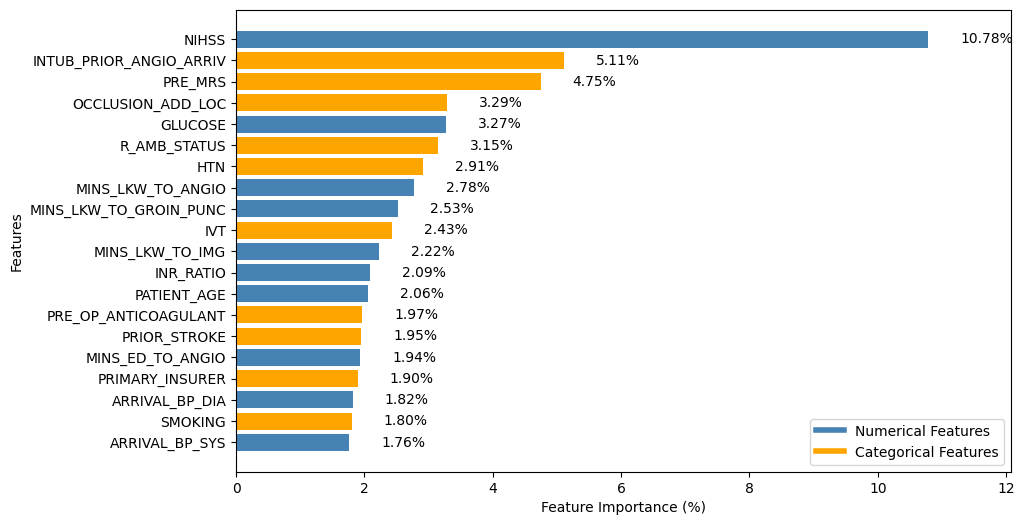

In [37]:
colors = []

for feature in features:
    if feature in num_names:
        colors.append('steelblue') 
    elif feature in cat_names:
        colors.append('orange')  
    else:
        colors.append('gray')  
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(features, scores, color=colors)
ax.set_xlabel('Feature Importance (%)')
ax.set_ylabel('Features')
ax.invert_yaxis() 
for i in range(len(scores)):
    ax.text(scores[i] + 0.5, i, f'{scores[i]:.2f}%', va='center')

# Adding legend
num_patch = plt.Line2D([0], [0], color='steelblue', lw=4, label='Numerical Features')
cat_patch = plt.Line2D([0], [0], color='orange', lw=4, label='Categorical Features')
ax.legend(handles=[num_patch, cat_patch], loc='lower right')
ax.set_xlim(0, max(scores) * 1.12)
plt.show()
